In [1]:
pip install --upgrade numpy==1.23.5 scipy nltk googletrans==4.0.0-rc1 textblob matplotlib torch transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
from googletrans import Translator
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax
from langdetect import detect


c:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load the dataset
df = pd.read_csv('Japan Public Sentiment 2-10-2024.csv')

In [5]:

# Initialize translator
translator = Translator()

# Function to translate and clean data
def translate_and_clean(text):
    try:
        translated = translator.translate(text, src='ja', dest='en').text
        # Add any additional cleaning steps here if needed
        return translated
    except:
        return ''

# Translate and clean data
df['translated_text'] = df['Post Body'].apply(translate_and_clean)


In [6]:
# Define keywords for renewable energy categories
energy_categories = {
    'Solar Energy': ['solar energy', 'solar panels', 'photovoltaic', 'sunlight'],
    'Wind Energy': ['wind energy', 'wind turbines', 'wind farms'],
    'Geothermal': ['geothermal', 'earth heat'],
    'Nuclear Energy': ['nuclear', 'reactors'],
    'Hydro Power': ['hydroelectric', 'dams', 'water turbines', 'hydro power'],
    'Bioenergy': ['biomass', 'biofuels', 'bioenergy'],
    'Ocean Energy': ['tidal energy', 'wave energy', 'ocean energy'],
    'Other': ['renewable energy']
}

def categorize_energy(text):
    text = text.lower()
    for category, keywords in energy_categories.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text):
                return category
    return 'Other'
# Apply the categorization function to the 'translated' column
df['Energy_Category'] = df['translated_text'].apply(categorize_energy)

In [7]:
# Define keywords for aspect categories
aspect_categories = {
    'Policy': ['policy', 'regulation', 'legislation', 'law', 'government', 'strategy'],
    'Jobs': ['job', 'employment', 'workforce', 'career', 'labor'],
    'Economy': ['economy', 'economic', 'gdp', 'growth', 'market'],
    'Tax': ['tax', 'subsidy', 'incentive', 'rebate', 'tariff'],
    'Investment': ['investment', 'funding', 'finance', 'capital'],
    'Technology': ['technology', 'innovation', 'research', 'development'],
    'Environment': ['environment', 'climate', 'emission', 'carbon', 'pollution'],
    'Cost': ['cost', 'price', 'expense', 'affordable', 'cheap', 'expensive'],
    'Infrastructure': ['infrastructure', 'grid', 'transmission', 'storage'],
    'Other': []  # This will catch any text that doesn't match the above categories
}

def categorize_aspect(text):
    text = text.lower()
    for category, keywords in aspect_categories.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text):
                return category
    return 'Other'

# Apply the categorization functions to the 'translated_text' column
df['Aspect_Category'] = df['translated_text'].apply(categorize_aspect)

In [8]:
# Preprocess the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['translated_text'].apply(preprocess_text)

# Convert 'Likes' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return float(value)

df['Likes_numeric'] = df['Likes'].apply(convert_to_numeric)


In [9]:

# TextBlob analysis by like count
df['textblob_sentiment'] = df['translated_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [10]:
# TextBlob sentment analyze
def analyze_sentiment(text):
    try:
        # Detect language
        lang = detect(text)
        
        # Translate to English if not already in English
        if lang != 'en':
            text = translator.translate(text, src=lang, dest='en').text
        
        # Perform sentiment analysis
        analysis = TextBlob(text)
        
        # Get polarity score (-1 to 1)
        polarity = analysis.sentiment.polarity
        
        # Convert polarity to 1-5 scale
        sentiment_score = 1 + (polarity + 1) * 2
        sentiment_score = max(1, min(5, sentiment_score))  # Ensure it's between 1 and 5
        
        return round(sentiment_score, 2)
    except:
        return None

# Apply sentiment analysis
df['TextBlob sentiment'] = df['translated_text'].apply(analyze_sentiment)

# Define sentiment categories
def categorize_sentiment(score):
    if score is None:
        return 'Unknown'
    elif score < 2:
        return 'Very Negative'
    elif score < 3:
        return 'Negative'
    elif score < 4:
        return 'Neutral'
    elif score < 4.5:
        return 'Positive'
    else:
        return 'Very Positive'

df['TextBlob sentiment_category'] = df['TextBlob sentiment'].apply(categorize_sentiment)



# Display results
print(df[['Post Body', 'TextBlob sentiment', 'TextBlob sentiment_category']].head())

# Print summary statistics
print("\nSentiment Distribution:")
print(df['TextBlob sentiment_category'].value_counts(normalize=True))

print("\nAverage Sentiment Score:", df['TextBlob sentiment'].mean())

                                           Post Body  TextBlob sentiment  \
0  【#神奈川14区】中村圭ウィークリーレポートです。日々、大変な暑さです。物価上昇でエアコンを...                2.83   
1                日本、約1.6兆円の気候変動債の募集を開始 - ESG Journal                3.00   
2  ドバイで開催されたCOP28（国連気候変動枠組み条約締約国会議）で、日本は世界の再生可能エネ...                2.75   
3  「これまでに経験したことのない大雨」が頻発する日本　集中豪雨と地球温暖化の関係とは – HA...                3.20   
4  【気候変動対策“逆行”の動き!?】\n\n日本同様、地球温暖化の影響とも思える記録的な暑さが...                2.92   

  TextBlob sentiment_category  
0                    Negative  
1                     Neutral  
2                    Negative  
3                     Neutral  
4                    Negative  

Sentiment Distribution:
TextBlob sentiment_category
Neutral          0.731563
Negative         0.230088
Very Positive    0.014749
Positive         0.014749
Very Negative    0.008850
Name: proportion, dtype: float64

Average Sentiment Score: 3.132083333333333


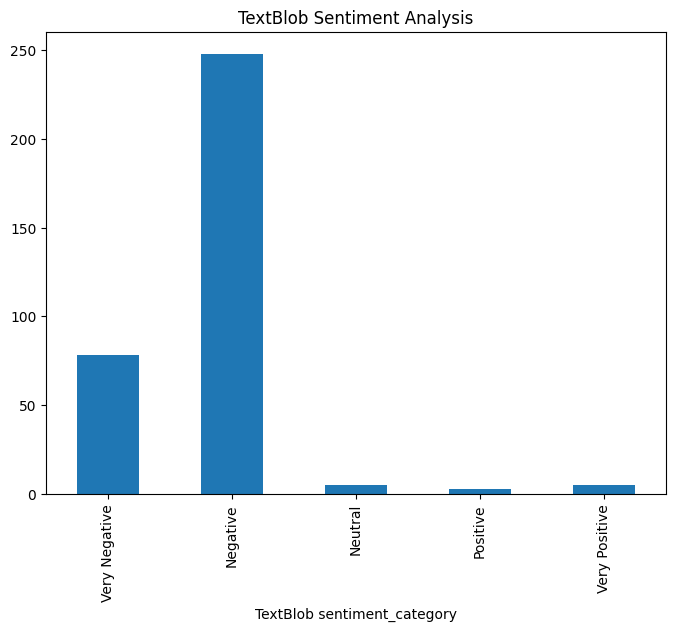

In [11]:

# Visualization for TextBlob sentiment analysis
plt.figure(figsize=(8, 6))
df['TextBlob sentiment_category'].value_counts().sort_index().plot(kind='bar')
plt.title('TextBlob Sentiment Analysis')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.show()

In [12]:

# BERT sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = softmax(outputs.logits.numpy(), axis=1)
    return scores.argmax() + 1

df['bert_sentiment'] = df['translated_text'].apply(bert_sentiment)

# Define sentiment categories
def categorize_sentiment(score):
    if score is None:
        return 'Unknown'
    elif score < 2:
        return 'Very Negative'
    elif score < 3:
        return 'Negative'
    elif score < 4:
        return 'Neutral'
    elif score < 4.5:
        return 'Positive'
    else:
        return 'Very Positive'

df['bert_sentiment category'] = df['bert_sentiment'].apply(categorize_sentiment)

# Display results
print(df[['Post Body', 'bert_sentiment', 'bert_sentiment category']].head())

# Print summary statistics
print("\nSentiment Distribution:")
print(df['bert_sentiment category'].value_counts(normalize=True))

print("\nAverage Sentiment Score:", df['bert_sentiment'].mean())


                                           Post Body  bert_sentiment  \
0  【#神奈川14区】中村圭ウィークリーレポートです。日々、大変な暑さです。物価上昇でエアコンを...               2   
1                日本、約1.6兆円の気候変動債の募集を開始 - ESG Journal               1   
2  ドバイで開催されたCOP28（国連気候変動枠組み条約締約国会議）で、日本は世界の再生可能エネ...               3   
3  「これまでに経験したことのない大雨」が頻発する日本　集中豪雨と地球温暖化の関係とは – HA...               3   
4  【気候変動対策“逆行”の動き!?】\n\n日本同様、地球温暖化の影響とも思える記録的な暑さが...               1   

  bert_sentiment category  
0                Negative  
1           Very Negative  
2                 Neutral  
3                 Neutral  
4           Very Negative  

Sentiment Distribution:
bert_sentiment category
Very Negative    0.377581
Negative         0.268437
Positive         0.165192
Very Positive    0.106195
Neutral          0.082596
Name: proportion, dtype: float64

Average Sentiment Score: 2.353982300884956


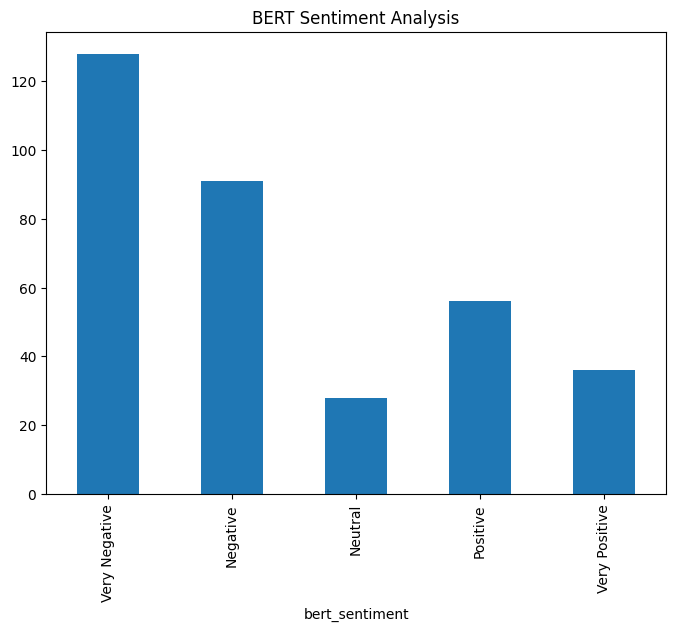

In [13]:

# Visualization for BERT sentiment analysis
plt.figure(figsize=(8, 6))
df['bert_sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('BERT Sentiment Analysis')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.show()


Agreement between TextBlob and BERT: 15.63%


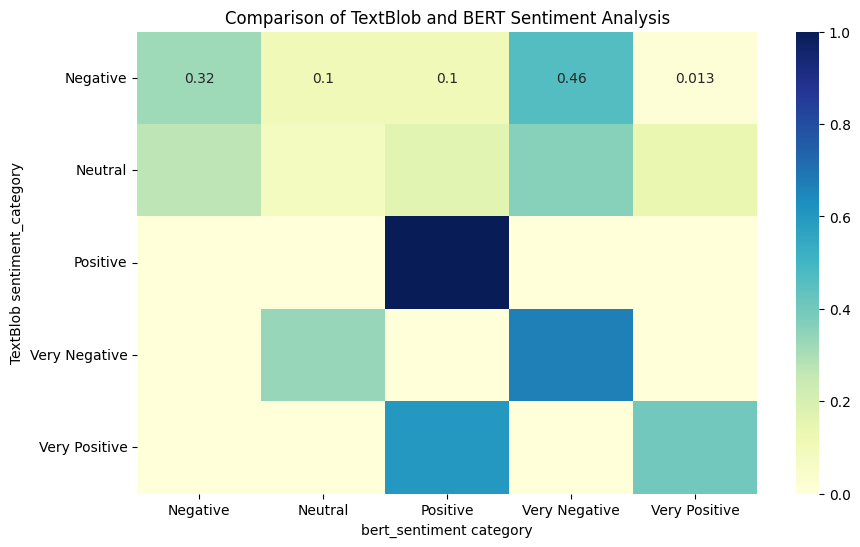

In [14]:

# Compare TextBlob and BERT results
df['bert_sentiment_category'] = df['bert_sentiment'].map({1: 'Very Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Very Positive'})
agreement = (df['TextBlob sentiment_category'] == df['bert_sentiment category']).mean()
print(f"Agreement between TextBlob and BERT: {agreement:.2%}")

# Visualization for comparison
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['TextBlob sentiment_category'], df['bert_sentiment category'], normalize='index'), annot=True, cmap='YlGnBu')
plt.title('Comparison of TextBlob and BERT Sentiment Analysis')
plt.show()


In [15]:
# Save the results to a CSV file
df.to_csv('Japan_sentiment_analysis_results 9-10-2024.csv', index=False)